# Simple Lane Detection

### Import Libraries

In [26]:
import cv2
import numpy as np
from IPython.display import display, clear_output
from PIL import Image
import matplotlib.pyplot as plt

__Load the Video Path__

In [27]:
# load video path
video_path = "sample_videos\Autonomous driving lane detection sample video 1.mp4"


### Helper Functions to Gray Scale, Gaussian Blur, Canny Edge Detection, Region of Interest, Hough Transform and Draw Lines

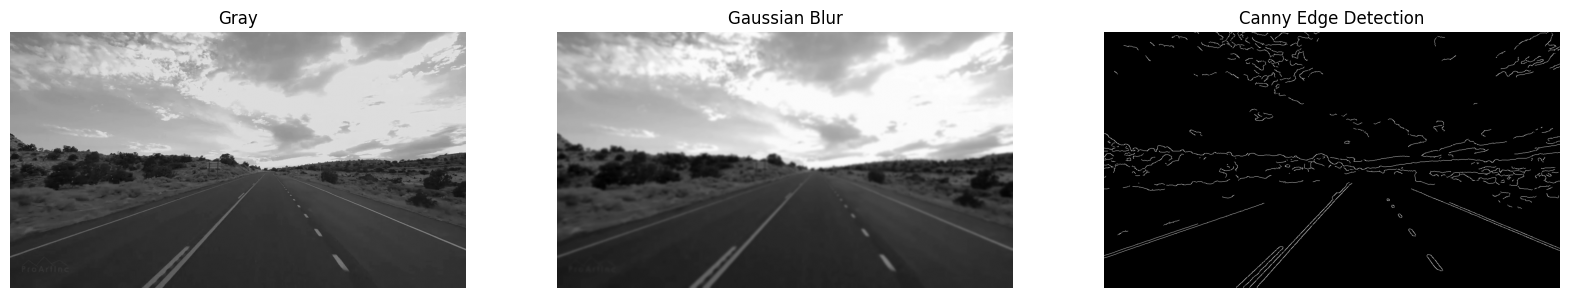

In [35]:
# change image frame to gray scale
def gray_scale(frame):
    return cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# apply gaussian blur to the image
def gaussian_blur(frame):
    # Ensure the kernel size is positive and odd
    kernel_size = (15, 15)
    if kernel_size[0] % 2 == 1 and kernel_size[1] % 2 == 1:
        return cv2.GaussianBlur(frame, kernel_size, 0)
    else:
        raise ValueError("Kernel size must be positive and odd")

# apply canny edge detection to the image
def canny_edge(frame):
    return cv2.Canny(frame, 20, 40)

# test on a single frame
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()

if ret:
    gray = gray_scale(frame)
    blur = gaussian_blur(gray)
    edge = canny_edge(blur)

    # plot the images side by side
    def plot_images(image_list,title_list=None):
        fig, axs = plt.subplots(1, len(image_list), figsize=(20, 20))
        for i, image in enumerate(image_list):
            axs[i].imshow(image, cmap='gray')
            axs[i].axis('off')
            if title_list:
                axs[i].set_title(title_list[i])
        plt.show()

    plot_images([gray, blur, edge], ['Gray', 'Gaussian Blur', 'Canny Edge Detection'])
else:
    print("Failed to read the video frame")

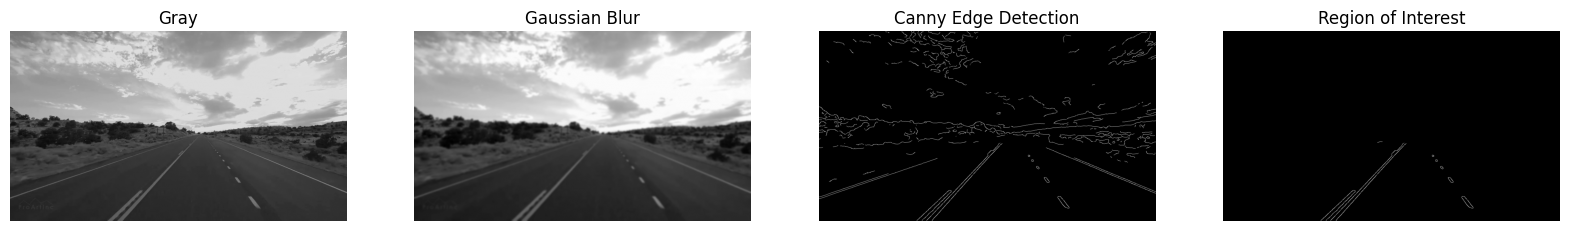

In [36]:


# Apply a trapezoidal mask to the frame
def region_of_interest(frame):
    height, width = frame.shape[:2]
    mask = np.zeros_like(frame)

    # Define a trapezoid region of interest
    polygon = np.array([
        [
            (int(width * 0.2), height), # bottom left
            (int(width * 0.8), height), # bottom right
            (int(width * 0.65), int(height * 0.57)), # top right
            (int(width * 0.45), int(height * 0.57)) # top left
        ]
    ], dtype=np.int32)

    # Fill the mask with the polygon
    cv2.fillPoly(mask, polygon, 255)

    # Apply the mask to the frame and return the result
    return cv2.bitwise_and(frame, mask)

# test on a single frame
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()

if ret:
    gray = gray_scale(frame)
    blur = gaussian_blur(gray)
    edge = canny_edge(blur)
    masked = region_of_interest(edge)

    plot_images([gray, blur, edge, masked], ['Gray', 'Gaussian Blur', 'Canny Edge Detection', 'Region of Interest'])
else:
    print("Failed to read the video frame")
    

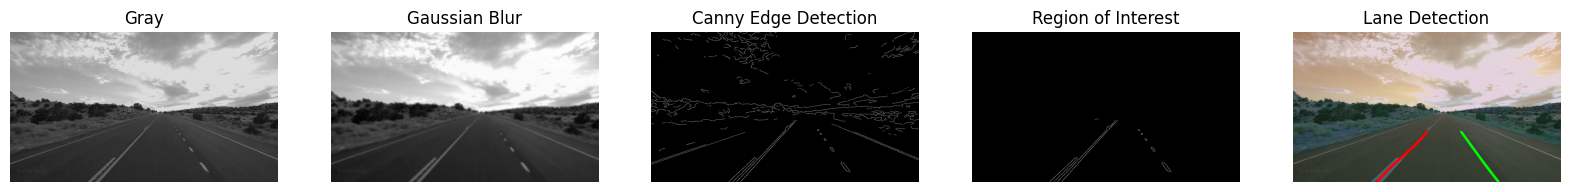

In [37]:
# Calculate curvature radius
def calculate_curvature(poly, y_vals):
    # Derivatives of the polynomial
    first_derivative = 2 * poly[0] * y_vals + poly[1]
    second_derivative = 2 * poly[0]
    return (1 + first_derivative**2)**1.5 / np.abs(second_derivative + 1e-6)

# Fit a polynomial to lane lines and draw them
def fit_polynomial(masked_edge, original_frame):
    # Find lane pixel indices
    lane_pixels = np.column_stack(np.where(masked_edge > 0))
    if len(lane_pixels) == 0:
        return np.zeros_like(original_frame)

    # Separate left and right lane pixels
    height, width = masked_edge.shape
    midpoint = width // 2 + 100
    left_lane_pixels = lane_pixels[lane_pixels[:, 1] < midpoint]
    right_lane_pixels = lane_pixels[lane_pixels[:, 1] >= midpoint]
    degree = 3

    def get_avg_curvature(pixels):
        if len(pixels) == 0:
            return
        y = pixels[:, 0]
        x = pixels[:, 1]

        poly = np.polyfit(y, x, degree)  # Fit a third-degree polynomial

        # Generate points along the fitted polynomial
        # Calculate curvature and adjust drawing range
        y_vals_full = np.linspace(int(height / 1.5), height - 1, num=int(height / 3), dtype=int)
        curvature = calculate_curvature(poly, y_vals_full)
        avg_curvature = np.mean(curvature)

        return avg_curvature
    def fit_and_draw_lane(pixels, color, avg_curvature):
        if len(pixels) == 0:
            return
        y = pixels[:, 0]
        x = pixels[:, 1]

        poly = np.polyfit(y, x, degree)  # Fit a third-degree polynomial

        # Adjust range based on curvature (shorter for tight curves)
        if avg_curvature < 1000:  # Example threshold for tight curves
            y_vals = np.linspace(int(height * 0.55), height - 1, num=int(height * 0.25), dtype=int)
        elif avg_curvature < 2000:  # Example threshold for moderate curves
            y_vals = np.linspace(int(height * 0.75), height - 1, num=int(height * 0.2), dtype=int)
        else:
            y_vals = np.linspace(int(height / 1.5), height - 1, num=int(height / 3), dtype=int)

        # x_vals = (poly[0] * y_vals**3 + poly[1] * y_vals**2 + poly[2] * y_vals + poly[3]).astype(int)
        x_vals = np.polyval(poly, y_vals).astype(int)
        # Draw the lane line
        valid_indices = (x_vals >= 0) & (x_vals < width)
        x_vals = x_vals[valid_indices]
        y_vals = y_vals[valid_indices]
        for i in range(len(x_vals) - 1):
            cv2.line(original_frame, (x_vals[i], y_vals[i]), (x_vals[i + 1], y_vals[i + 1]), color, 10)

    # Fit and draw left and right lanes
    left_avg_curvature = get_avg_curvature(left_lane_pixels)
    right_avg_curvature = get_avg_curvature(right_lane_pixels)
    if left_avg_curvature is None or right_avg_curvature is None:
        return original_frame
    min_curvature = min(left_avg_curvature, right_avg_curvature)
    fit_and_draw_lane(left_lane_pixels, (255, 0, 0), min_curvature)  # Left lane in blue
    fit_and_draw_lane(right_lane_pixels, (0, 255, 0), min_curvature)  # Right lane in green

    return original_frame


# test on a single frame
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()

if ret:
    gray = gray_scale(frame)
    blur = gaussian_blur(gray)
    edge = canny_edge(blur)
    masked = region_of_interest(edge)
    lanes = fit_polynomial(masked, frame)

    plot_images([gray, blur, edge, masked, lanes], ['Gray', 'Gaussian Blur', 'Canny Edge Detection', 'Region of Interest', 'Lane Detection'])
else:
    print("Failed to read the video frame")
    

In [ ]:
# Read the video frame by frame and apply lane detection
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    # convert to gray scale
    gray = gray_scale(frame)

    # apply gaussian blur
    blur = gaussian_blur(gray)

    # apply canny edge detection
    edge = canny_edge(blur)

    # Apply the region of interest mask
    masked_edge = region_of_interest(edge)

    # Fit polynomial to lanes and draw them on the frame
    lanes_frame = fit_polynomial(masked_edge, frame.copy())


    # Calculate curvature and display as text
    lane_pixels = np.column_stack(np.where(masked_edge > 0))
    if len(lane_pixels) > 0:
        y_vals = np.linspace(masked_edge.shape[0] // 2, masked_edge.shape[0] - 1, num=50)
        poly = np.polyfit(lane_pixels[:, 0], lane_pixels[:, 1], 2)  # Fit a 2nd-degree polynomial
        curvature = calculate_curvature(poly, y_vals)
        avg_curvature = np.mean(curvature)
        curvature_text = f"Curvature Radius: {avg_curvature:.2f} m"
    else:
        curvature_text = "Curvature Radius: Not Detected"

    # Add curvature text at the top of the frame
    cv2.putText(lanes_frame, curvature_text, (450, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (186, 105, 0), 2)

    # Create insets for Canny edges and masked output
    edge_resized = cv2.resize(edge, (200, 150))  # Resize to fit as inset
    edge_colored = cv2.cvtColor(edge_resized, cv2.COLOR_GRAY2BGR)  # Convert to BGR for consistency
    blur_resized = cv2.resize(blur, (200, 150))  # Resize to fit as inset
    blur_colored = cv2.cvtColor(blur_resized, cv2.COLOR_GRAY2BGR)  # Convert to BGR for consistency

    # Overlay insets on the main frame
    lanes_frame[10:160, 10:210] = blur_colored  # Place Masked inset next to Canny inset
    lanes_frame[10:160,230:430 ] = edge_colored  # Place Canny inset at top-left

    # Add titles to the insets
    cv2.putText(lanes_frame, "Gaussian Blurred Video", (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    cv2.putText(lanes_frame, "Canny Edges", (230, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

    # Display the combined frame
    cv2.imshow("Lane Detection", lanes_frame)


    # video 60 fps, wait according to fps
    cv2.waitKey(1000 // 60)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        cv2.destroyAllWindows()
        break

cap.release()



## For running in jupyter notebook

In [ ]:
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    # convert to gray scale
    gray = gray_scale(frame)

    # apply gaussian blur
    blur = gaussian_blur(gray)

    # apply canny edge detection
    edge = canny_edge(blur)

    # Apply the region of interest mask
    masked_edge = region_of_interest(edge)

    # Fit polynomial to lanes and draw them on the frame
    lanes_frame = fit_polynomial(masked_edge, frame.copy())


    # Calculate curvature and display as text
    lane_pixels = np.column_stack(np.where(masked_edge > 0))
    if len(lane_pixels) > 0:
        y_vals = np.linspace(masked_edge.shape[0] // 2, masked_edge.shape[0] - 1, num=50)
        poly = np.polyfit(lane_pixels[:, 0], lane_pixels[:, 1], 2)  # Fit a 2nd-degree polynomial
        curvature = calculate_curvature(poly, y_vals)
        avg_curvature = np.mean(curvature)
        curvature_text = f"Curvature Radius: {avg_curvature:.2f} m"
    else:
        curvature_text = "Curvature Radius: Not Detected"

    # Add curvature text at the top of the frame
    cv2.putText(lanes_frame, curvature_text, (450, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (186, 105, 0), 2)

    # Create insets for Canny edges and masked output
    edge_resized = cv2.resize(edge, (200, 150))  # Resize to fit as inset
    edge_colored = cv2.cvtColor(edge_resized, cv2.COLOR_GRAY2BGR)  # Convert to BGR for consistency
    blur_resized = cv2.resize(blur, (200, 150))  # Resize to fit as inset
    blur_colored = cv2.cvtColor(blur_resized, cv2.COLOR_GRAY2BGR)  # Convert to BGR for consistency

    # Overlay insets on the main frame
    lanes_frame[10:160, 10:210] = blur_colored  # Place Masked inset next to Canny inset
    lanes_frame[10:160,230:430 ] = edge_colored  # Place Canny inset at top-left

    cv2.putText(lanes_frame, "Gaussian Blurred Video", (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    cv2.putText(lanes_frame, "Canny Edges", (230, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

    # Display the combined frame
    cv2.imshow("Lane Detection", lanes_frame)

    # Convert BGR to RGB for Jupyter Notebook compatibility
    lanes_frame_rgb = cv2.cvtColor(lanes_frame, cv2.COLOR_BGR2RGB)

    # Convert to PIL image for display
    img = Image.fromarray(lanes_frame_rgb)

    # Display in Jupyter Notebook
    clear_output(wait=True, )  # Clear the previous frame
    display(img)

    # Simulate video frame rate
    if cv2.waitKey(1000 // 60) & 0xFF == ord('q'):
        break


cap.release()

